In [62]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [63]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [64]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [65]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,' # We don't need a GPU to test the model

In [66]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [67]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  500000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  2000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  200,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : False,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : "pretrain_q_learning",
"step_size" : 4,
}

for key,val in all_params.items():
    exec(key + '=val')

In [47]:
# Setup environment 
session_name = 'rand_walk_interpol'
env = RLEnv(model_path=session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.
2023-05-26 18:44:02.774350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 18:44:02.774543: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-26 18:44:02.774649: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-26 18:44:02.774971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at

INFO:tensorflow:Clearing prior device assignments in loaded saved model


INFO:tensorflow:Clearing prior device assignments in loaded saved model
2023-05-26 18:44:03.243944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 18:44:03.244162: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-26 18:44:03.244252: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-26 18:44:03.244521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L35

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.
2023-05-26 18:44:05.457107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 18:44:05.457298: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-26 18:44:05.457393: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-26 18:44:05.457659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at

INFO:tensorflow:Clearing prior device assignments in loaded saved model


INFO:tensorflow:Clearing prior device assignments in loaded saved model
2023-05-26 18:44:05.776009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 18:44:05.776226: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-26 18:44:05.776315: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-26 18:44:05.776545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L35

In [68]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-05-26--18:59:40'

In [49]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [50]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

Reward per epsisode 93.19999724626541
Average error 21.092665099607952


Timer unit: 0.001 s

Total time: 21.4732 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 405

Line #      Hits         Time  Per Hit   % Time  Line Contents
   405                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   406        52          0.1      0.0      0.0  		city_ob = self.building_grid
   407        52          0.2      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   408        52          0.3      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   409                                           
   410                                           		# Get measured coords
   411        52          6.3      0.1      0.0  		measured_coords = self.get_measured_coords()
   412                                           
   413                                           		# UAV location grid
   414        52          0.3      0.0      0.0  		uav_location_grid

In [69]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=51,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


Using standard DQN


In [70]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=0,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

Using standard DQN agent


In [53]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors)

In [54]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=1)

print((rand_reward, rand_pred_error))


(84.800026, 22.317278266545422)


In [15]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,     
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmppkwdw5vo.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmppkwdw5vo
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44297


In [16]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps
Traversed 109999 steps
Traversed 119999 steps
Traversed 129999 steps
Traversed 129999 steps
Traversed 139999 steps
Traversed 149999 steps
Traversed 159999 steps
Traversed 169999 steps
Traversed 179999 steps
Traversed 189999 steps
Traversed 199999 steps
Traversed 209999 steps
Traversed 219999 steps
Traversed 229999 steps
Traversed 239999 steps
Traversed 249999 steps
Traversed 259999 steps
Traversed 269999 steps
Traversed 279999 steps
Traversed 289999 steps
Traversed 299999 steps
Traversed 309999 steps
Traversed 319999 steps
Traversed 329999 steps
Traversed 339999 steps
Traversed 349999 steps
Traversed 359999 steps
Traversed 369999 steps
Traversed 379999 steps
Traversed 389999 steps
Traversed 399999 steps
Traversed 409999 steps
Traversed 419999 steps
Traversed 429999 steps

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([[[ 0.58021325,  0.17666778,  0.        ],
         [ 0.52044046,  0.2012929 ,  1.        ],
         [ 0.35974848,  0.17441177,  0.        ],
         ...,
         [ 0.23626626,  0.13024193,  0.        ],
         [ 0.30269092,  0.13024814,  0.        ],
         [ 0.3499258 ,  0.19020544,  0.        ]],
 
        [[ 0.7768441 ,  0.14401409,  0.        ],
         [ 0.        ,  0.28792685,  0.        ],
         [ 0.        ,  0.2369239 ,  0.        ],
         ...,
         [ 0.        ,  0.16924132,  0.        ],
         [ 0.31486848,  0.15729283,  0.        ],
         [ 0.41220573,  0.1472876 ,  0.        ]],
 
        [[ 0.7797603 ,  0.13397229,  0.        ],
         [ 0.        ,  0.19058163,  0.        ],
         [ 0.        ,  0.21097808,  0.        ],
         ...,
         [ 0.        ,  0.13094912,  0.        ],
         [ 0.40511882,  0.1267087 ,  0.        ],
         [ 0.49163407,  0.14971   ,

In [71]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [72]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [57]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [58]:
env._reset()
print("")

In [73]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [74]:
best_reward = np.inf
num_eval_episodes = 100
losses = []
collect_rewards = []

In [75]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (616312) so Table uniform_table is accessed directly without gRPC.
2023-05-26 19:00:22.259995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'loss/td_error/histogram/write_summary/buckets/cond/zeros/packed/loss/td_error/histogram/write_summary/buckets/Maximum' with dtype int32
	 [[{{node loss/td_error/histogram/write_summary/buckets/cond/zeros/packed/loss/td_error/histogram/write_summary/buckets/Maximum}}]]
2023-05-26 19:00:22.266486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'loss/td_error/histogram/write_summary/buckets/cond/cond/Fill/di

step = 0: loss = 111.5118637084961,  rew = 103.91926765441895
step = 1000: loss = 107.58396911621094,  rew = 107.31770992279053
step = 2000: loss = 95.00366973876953,  rew = 104.1015625
step = 3000: loss = 95.81130981445312,  rew = 107.68229961395264
step = 4000: loss = 115.61007690429688,  rew = 103.93229722976685
step = 5000: loss = 81.5406494140625,  rew = 107.31770992279053
step = 6000: loss = 133.361083984375,  rew = 108.19010734558105
step = 7000: loss = 114.70054626464844,  rew = 102.734375
step = 8000: loss = 89.2706298828125,  rew = 106.73176050186157
step = 9000: loss = 226.54750061035156,  rew = 102.18750238418579
step = 10000: loss = 106.46971130371094,  rew = 102.07031965255737
step = 11000: loss = 54.18677520751953,  rew = 97.64323234558105
step = 12000: loss = 249.4268798828125,  rew = 105.87239265441895
step = 13000: loss = 133.9117431640625,  rew = 98.9453136920929
step = 14000: loss = 677.1214599609375,  rew = 105.078125
step = 15000: loss = 95.48893737792969,  rew = 

In [76]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step.reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)

step = 500000: loss = 529.2894287109375,  rew = 104.54338788986206
step = 500000: Average Return = 96.95201110839844, Average Error = 22.511984405098037
Saving model
step = 501000: loss = 411.1407470703125,  rew = 93.26000213623047
step = 502000: loss = 177.91494750976562,  rew = 99.12000894546509
step = 503000: loss = 312.48223876953125,  rew = 93.23500394821167
step = 504000: loss = 104.26191711425781,  rew = 95.85999250411987
step = 505000: loss = 250.19241333007812,  rew = 78.2450020313263
step = 506000: loss = 381.4720458984375,  rew = 102.7649998664856
step = 507000: loss = 103.30410766601562,  rew = 90.5299961566925
step = 508000: loss = 172.59466552734375,  rew = 101.32499933242798
step = 509000: loss = 140.96324157714844,  rew = 102.7750015258789
step = 510000: loss = 423.49932861328125,  rew = 97.18499779701233
step = 511000: loss = 347.0697937011719,  rew = 93.92499327659607
step = 512000: loss = 368.3727111816406,  rew = 100.38000345230103
step = 513000: loss = 311.64907836

In [ ]:
temp_schedule.temp = 0.0

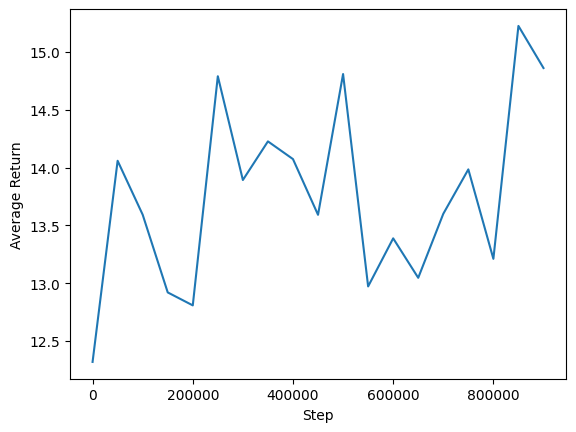

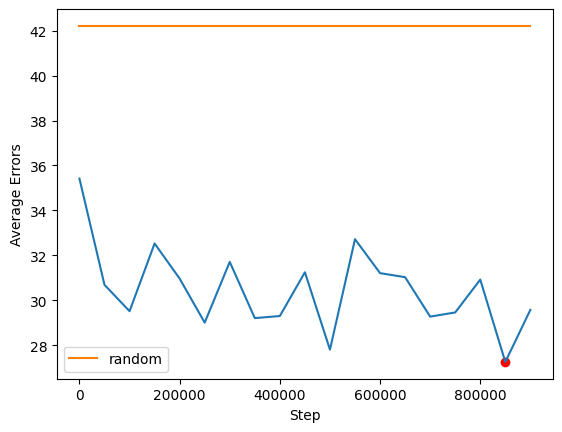

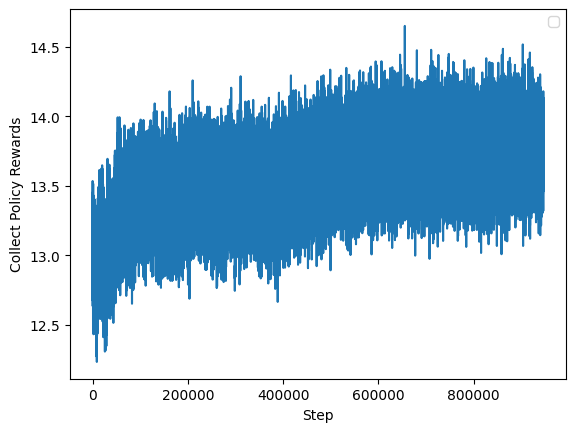

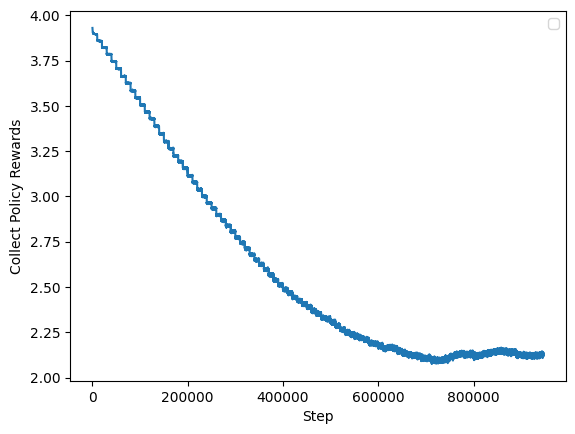

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/enesk/miniconda3/e

KeyboardInterrupt: 

In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

14.793147 25.72983358634253
